# How to group users and identify outliers in a log stream, based on behaviour


## What is demonstrated in this notebook

In this notebook I demonstrate, from a (generated) stream of logs, how to group users by behaviour, and how to highlight which behaviour group an analyst should focus his attention on. 

This method is good when monitoring a stable and closed system, with a finite number of possible actions, and known definition of success and failure.

Probabilities are based on a "Subject (unique key), Action (ex.: login), Outcome (success/fail)" discrete format. Continuous Action variables (like numerical values) would need to be reduced to discrete output to fit this model.

## Why is this a hard problem?

What is a normal action? Which one is suspect? The answer is "it depends". 

To group individual together, we need a way to classify each action taken over time, and somehow group them together.

A clustering function like KMean requires us to know how many cluster we have, and we need mesurable features to group them together. Normal clustering functions lose in efficiency the more we add features.

Machine learning techniques are also great to identify patterns over a large number of repeating features, but struggle to handle unusual events especially when data is skewed by a high volume of "normal" actions. This is why when we do text analysis, we normally remove common [English stop words](https://www.ranks.nl/stopwords). But what if these stop words were necessary to identfy an outlier? How can we keep them without debalancing everything?

One other hypothesis would be to use Hidden Markov Chains, but for HNN, we need classified data. Sequences also need to be somehow of a consistent length, but users are most likely not to follow a straight pattern from A to B, which complicates the creation of HMM.

Another approach would be to use rules. Classically, Intrusion detection systems recognize a set of patterns, and uses thresholds to know when to raise a flag, generating a large number of false positive. A rule based system is also unlikely to be able to detect the usage of normal functions in an abusive way.

In the end, we need each features from all possible events to be classified and scored somehow, and we need a way to group these scores together.

## Approach taken

### What this notebook is the following

* Step 1: We calculate the probability of each sequences of actions being taken by all users over a defined period of time (ex.: 1 day). From these probabilities, we create a lookup probability table for each possible sequence.
* Step 2: For each users, we sum the probability (using logarithm base 2) for each action taken. Depending on the likelyhood of each action, this tells us how much new information we learned from the actions taken by a user, defining a action profile for each user.
* Step 3: Using the profiles created on Step 2, we group them together by calculating how much information is gained if we compare each actions together. If the information gained is low, then we know that both users had a similar action pattern. If the information gained is high, then they have different behaviour.
* Step 4: With all users grouped together, we can quickly analyse a group of user and label that group with a usage profile. The way these profiles are caculated here should keep them stable over time. If new behaviours are observed, new groups will be created. An analyst then only have to pay attention to the new group and groups identified as malicious when monitoring a system.

### Caviats

* For Step 1, this can be done on a live stream of logs, but for systems generating a large quantify of logs, this could result in integer overflow if we are dealing with too many events. Using rolling windows (ex.: calculate for a period, then use these probabilities distribution to analyse the next period, while creating a new distribution for the next period) might be a better solution.
* For Step 2, this works better when there is a clear start and end of sequence for a user. As it is coded right now, scoring a partial session would end up creating a large quantity of behaviour groups, which would be noisy.
* For Step 3, the "distance" (which isn't) between each users is somewhat arbitrary selected. Litmits should be adjusted depending on the number of events on the system. On small simulations, larger values (5-10) worked well. However, if the quantity of events is really high, a smaller distance (1-3) might be necessary. Using too strict limits will generate a large number of groups to represent all possible behaviours, but if we use a larger maximum limit (ex.: 10), then we increase the likelihood of having misclassifications and group outlier with normal users.
* For Step 4: None here :-D This is where I would start configuring rules or send data to a machine learning model, because users are now classified in limited groups.

## The theory behind the approach

Formulas are inspired from Information Theory, and they are normally used for signal analysis and compression. 
* Step 2 consist of using Surprisal: by calculating the entropy of each action, we can assign a score on each action, representing how surprised we should be when we see an action happening.
* Step 3 uses the Kullback–Leibler divergence formula. This normally tells us how much information is gained by comparing two probabilities together. However, this formula isn't symetric. By calculating both possibilities, we can get an idea how close two profiles are, and use this to group similar behaviours together.

* [Information Content](https://en.wikipedia.org/wiki/Information_content)
* [Surprisal Analysis](https://en.wikipedia.org/wiki/Surprisal_analysis)
* [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
* [Example of Surprisal](http://www.umsl.edu/~fraundorfp/egsurpri.html)

Example of how to calculate surprisal:
* There is 1/6 chance to roll a 6 on a d6 die, gives us -log2(1/6) ~= 2.4849 bits of information. If you are playing D&D, you will be happily surprised.
* Not rolling a 6 on a die represents -log2(5/6) ~= 0.263 bits. So rolling anything but a 6 in that same D&D game will most likely leave you dissapointed. 
* The chance of rolling 10 x 6 in a row on a die is 1/60466176 (10 * -log2(1/6) ~= 25.85 bits). This is highly unlikely.

So later when we look at the surprisal score of a user and we see 51550 (bits), this tells us that the actions taken by this user are really, really unlikely.

This also tells us that if the total surprisal score of the actions of a user is low, then we can safely assume that the actions taken by that user are normal. But by repeating a large number of normal actions together, the score will pile up and single out the user.

Surprisal are calculated using Log base 2, which has the nice particularity to be additive instead of being multiplied like probabilities, keeping numbers relatively small and easy to manipulate.

## Demonstration

This is what this notebook intend to demonstrate: Using Surprisal analysis, we will assign a score to actions, and by adding up the score of each action, identify series of actions that are unlikely to occur, then group users by their action profile.


# Step 0: We need logs

What is explained in this notebook can be applied to real logs, but for the experimentation, I generate logs for simulated users based on a determined probability distribution.

## Caviat: I use some cheats to demonstrate how the notebook works...

These cheats are not necessary to make this technique work and are clearly identified when used. I did use one of these cheat at first to identify the most efficient Kullback-Leibler divergence limit to use in Step 3. 


## Different User Profiles Generated By The Library

The following profiles are being generated.

Normal users
* Buyer
* Merchants

Abnormal users:
* Scraper bots
* Spammers
* fraudster
* Account Attackers

Buyers and merchants represent 98% of our logs. Leaving 2% to the abnormal users. However, the actions taken by each users being on a probability distribution. 

It is possible to see an "attakcer" user being classified as a user, because that attacked might have had a change of heart and didn't attack after all. This allows us to demonstrate that this approach is not perfect: a small quantity of unlikely actions will most probably pass under the radar if we just look at the score of each user. That attacker might however be identified if the actions doesn't match the ones of normal users, which would generate a new group and single him/her out.


In [1]:
## This cell initialize the libraries needed for this notebook, 
## along with the blackbox functions used to generate the users and logs

import random
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
from math import log, pow
import timeit

chrono_start = timeit.default_timer()

%load_ext autoreload
%autoreload 2

from distribution_from_file import check_if_ok

if check_if_ok() and 0: # Check if there is a real probability distribution of user actions in the notebook directory
    from distribution_from_file import generate_userlist, generate_logs, cheat_calculate_hit_rate, cheat_lookup_all_users
else: # For demonstration purpose, this is what will be used to generate users and logs
    from blackbox import generate_userlist, generate_logs, cheat_calculate_hit_rate, cheat_lookup_all_users
    

# Step 0.1: Generating The User Database

The following cells generates our users.

Note: I often reinitializing the random seed, just to keep the testing consistence. Setting *random_seed* to False will generate new data every time.

In [2]:
## Initial number of users in our system
number_of_daily_users = 1000 # The more we add users, the longer the notebook takes to run.

In [3]:
random_seed = 42

if random_seed:
    random.seed(random_seed)

all_user_lists = [] # Later on, we can add users to our list by supplying it to the generate_userlist function

## We define how many new users to add
number_of_new_users = number_of_daily_users - len(all_user_lists)

all_user_lists = generate_userlist(all_user_lists, number_of_new_users)
todays_user_lists = random.sample(all_user_lists, number_of_daily_users)

print(len(todays_user_lists), 'users in the database.')
print('Type of the 15 firsts:', todays_user_lists[:15])

1000 users in the database.
Type of the 15 firsts: ['merchant', 'merchant', 'merchant', 'merchant', 'merchant', 'merchant', 'merchant', 'merchant', 'merchant', 'merchant', 'buyer', 'buyer', 'buyer', 'buyer', 'merchant']


# Step 0.2: Generating Logs For Day 1

Note: The more users we have, the more log events will be generated. 

The probability distribution of each user ensures that they will start with a defined action, crawl the site following a defined pattern, and logout eventually, until the end of the day.

In [4]:
%%time
if random_seed:
    random.seed(random_seed)

start_time = datetime(2019,1,1,0,0)
day1_logs = generate_logs(todays_user_lists, start_time)

print(len(day1_logs), 'log events generated for', len(todays_user_lists), 'users')

17125 log events generated for 1000 users
CPU times: user 1.32 s, sys: 12.6 ms, total: 1.33 s
Wall time: 1.37 s


## Transforming the logs in a pandas dataframe (for this notebook...)

The transition surprisal lookup table used in this notebook calculates scores based on the movements of the users between each actions. For example:

* login -> view_items (success) will result in a low surpisal value
* login -> buy_item (success) never happened. If this sequence happen, this should be a huge red flag.

Note: I skipped one feature: the status (success/failure) of the previous path isn't taken into consideration. Adding it would definitely make the calculations more sensitive to anomalies, but with the cost of an increase on complexity.

In [5]:
def transform_logs_to_pandas(logs):
    data = pd.DataFrame(np.array(logs), columns=['time', 'user', 'path', 'status', 'uidx', 'realtype'])
    
    data['prev_path'] = data.groupby(['user'])['path'].shift(1)
    data['prev_path'] = data['prev_path'].fillna("")
    return data
    
day1_data = transform_logs_to_pandas(day1_logs)


# Example of failed actions in the logs. uidx and realtype are "cheat" columns, and not necessary in a real case usage.
print(day1_data.loc[(day1_data['path'] == 'login') & (day1_data['status'] == 'fail')].head())

                    time         user   path status uidx  realtype prev_path
730  2019-01-01 01:49:32  attacker300  login   fail  300  attacker          
731  2019-01-01 01:49:37  attacker300  login   fail  300  attacker     login
732  2019-01-01 01:49:41  attacker300  login   fail  300  attacker     login
734  2019-01-01 01:49:44  attacker300  login   fail  300  attacker     login
735  2019-01-01 01:49:46  attacker300  login   fail  300  attacker     login


## Step 1 : Generate the transition lookup table

**This is where the magic trick happens.**

The following cell generates the transition lookup table used to score each actions taken by the users.

The format is as follow:

```
['current path'],['previous path']: {
    'fail': 0, # How many time this action transition failed. (ex. View Items: Success, from: Login: Success)
    'success': 13, # How many time this action transition succeded (ex. View Items: Fail, from: Login: Success)
    'fsurprisal': 11.266786540694902, # Surprisal value if there is a failure happens
    'ssurprisal': 7.56634682255381 # Surprisal value if that action is successful.
    }
```

The surprisal value is directly related to the likelihood of an actions happening. If an actions is observed successfully few million times, then the successful surprisal value will be really low. However, the failure surprisal will be much higher if an action/status never or rarely happens.

In [6]:
def init_transition_surprisal_lookup(data, key, prev_key, feature, success):
    surprisal = {}

    for pkey in data[key].unique():
        data_for_pkey = data.loc[(data[key] == pkey)]
        denum = len(data.loc[(data[key] == pkey)])

        for ppkey in data_for_pkey[prev_key].unique():
            ds = data_for_pkey.loc[(data_for_pkey[prev_key] == ppkey) & (data_for_pkey[feature] == success)]
            df = data_for_pkey.loc[(data_for_pkey[prev_key] == ppkey) & (data_for_pkey[feature] != success)]

            dsuccess = len(ds) * 1.0
            dfail = len(df) * 1.0

            if dsuccess == 0:
                dsuccess = 1.0 

            if dfail == 0:
                dfail = 1.0

            if (pkey not in surprisal.keys()):
                surprisal[pkey] = {}

            surprisal[pkey][ppkey] = {
                'success': len(ds),  # Not used later one, just interesting for debugging
                'fail': len(df),  # Not used later one.
                'ssurprisal': log(1/(dsuccess / denum),2), # Magic!!
                'fsurprisal': log(1/(dfail / denum),2), # Magic!!
            }
    return surprisal

transition_surprisal = init_transition_surprisal_lookup(day1_data, 'path', 'prev_path', 'status', 'success')

The next cell creates a wrapper function to query the transition surprisal lookup table. If the sequence was previously observed, it will return it, and will return the probability of 1 over the total number of actions taken (unlikely) for unobserved events, making them stand out.

In [7]:
def get_transition_surprisal(path, prev_path, surprisal, data):
    if path not in list(surprisal.keys()):
        denum = len(data)
        return {
            'fail': 0,
            'success': 0,
            'ssurprisal': log(1/(1/denum),2),
            'fsurprisal': log(1/(1/denum),2),
        }
    else:
        if prev_path not in list(surprisal[path].keys()):
            denum = len(data.loc[(data['path'] == path)])
            return {
                'fail': 0,
                'success': 0,
                'ssurprisal': log(1/(1/denum),2),
                'fsurprisal': log(1/(1/denum),2),
            }
        else:
            return surprisal[path][prev_path]

# Usage example: what is the surprisal values for a "buy_item" action 
# if the user just logged in on the previous action?
get_transition_surprisal('buy_item', 'login', transition_surprisal, day1_data)

{'fail': 1,
 'fsurprisal': 10.303780748177104,
 'ssurprisal': 6.981852653289741,
 'success': 10}

# Step 2: For each users, sum the probability for all actions taken.

The following function takes the dataframe with all the logs for a day, and returns the sum of the surprisal values, conditional to a success or a failure, for all actions taken by a user.

In [8]:
def get_user_transition_score(data, surprisal, key, feature, success_val):
    accumulator = {}
    key_last_path = {}
    
    for index,row in data.iterrows():
        if row[key] not in key_last_path.keys():
            key_last_path[row[key]] = ""
            
        if row[key] not in accumulator.keys():
            accumulator[row[key]] = {k:0 for k in data[feature].unique()}
            
        if row[feature] is success_val:
            accumulator[row[key]][row[feature]] += get_transition_surprisal(row[feature],key_last_path[row[key]], surprisal, data)['ssurprisal']
        else:
            accumulator[row[key]][row[feature]] += get_transition_surprisal(row[feature],key_last_path[row[key]], surprisal, data)['fsurprisal']

        key_last_path[row[key]] = row[feature]
                                    
    return accumulator


user_transition_score = get_user_transition_score(day1_data, transition_surprisal, 'user', 'path', 'success')

## Optional (but useful): Identify who are the main offenders

The following three cells calculate the mean and standard deviation of each users, and display the users with a score of 2 or more standard deviations.

In [9]:
cumulative_score = [[v,sum(user_transition_score[v].values())] for v in [k for k in list(user_transition_score.keys())]]

df_cumulative_score = pd.DataFrame(cumulative_score, columns=['user', 'surprisal'])

avg = df_cumulative_score['surprisal'].mean()
std = df_cumulative_score['surprisal'].std()
df_cumulative_score['z'] = (df_cumulative_score['surprisal'] - avg) / std


In [10]:
# List all users with a zscore over 2.
df_cumulative_score.loc[df_cumulative_score['z'] >= 2].sort_values(by=['surprisal'], ascending=False)

,user,surprisal,z
820,bot269,25835.299997,31.331366
595,bot196,2205.136719,2.515226


In [11]:
# List the 10 most boring users.
df_cumulative_score.sort_values(by=['surprisal'], ascending=False).tail(10)

,user,surprisal,z
519,buyer392,34.754297,-0.131478
130,buyer752,34.754297,-0.131478
998,buyer528,27.276347,-0.140597
911,buyer133,25.485170,-0.142782
720,buyer968,25.485170,-0.142782
375,fraudster434,24.450516,-0.144043
389,attacker695,24.113605,-0.144454
506,fraudster763,19.647497,-0.149900
721,attacker672,9.958553,-0.161716
330,merchant204,9.958553,-0.161716


## Cheat cell: Identify the ideal "distance" to increase the True Positive rate, and reduce the False Positive Rate

Without using this cheat, we need to guess the ideal Kullback-Leibler divergence limit. 

* From experimentation, this should be between 4 and 8. 9 and more did tend to cause a higher False Positive rate.
* Values too small are likely to reduces the number of false positives, but will end up create more behaviour profiles
* Values too big will result in a smaller number of groups, and more misclassification


In [12]:
np.seterr(divide='ignore', invalid='ignore', over='ignore')

if random_seed:
    np.random.seed(random_seed)

maxlimit = 1
maxtp = 0
mintn = 1
best_flat_lookup = {}

for l in range(2, 10):
    flat_status, flat_lookup = cheat_calculate_hit_rate(day1_data, user_transition_score, l)
    if maxtp <= flat_lookup[True][True] and mintn >= flat_lookup[True][False]:
        maxtp = flat_lookup[True][True]
        mintn = flat_lookup[True][False]
        maxlimit = l
        print('best', l, flat_lookup, maxtp, mintn, (maxtp+mintn)/2,maxlimit)
    

flat_status, flat_lookup = cheat_calculate_hit_rate(day1_data, user_transition_score, maxlimit)

print('limit', maxlimit)
print('count', True, flat_status[True])
print('count', False, flat_status[False])

print('percent', True, flat_lookup[True])
print('percent', False, flat_lookup[False])


best 2 {True: {True: 0.9411764705882353, False: 0.14514692787177205}, False: {True: 0.058823529411764705, False: 0.8548530721282279}} 0.9411764705882353 0.14514692787177205 0.5431616992300037 2
best 5 {True: {True: 0.9459459459459459, False: 0.13824057450628366}, False: {True: 0.05405405405405406, False: 0.8617594254937163}} 0.9459459459459459 0.13824057450628366 0.5420932602261148 5
limit 5
count True {True: 102, False: 6}
count False {True: 157, False: 960}
percent True {True: 0.9444444444444444, False: 0.1405550581915846}
percent False {True: 0.05555555555555555, False: 0.8594449418084154}


In [13]:
# Bypassing the cheat function and forcing the maximum Kullback-Leibler divergence limit.
maxlimit = 5

# Step 3: Grouping users by their behaviour

The second magic trick is in the compare_profiles() function

In [14]:
# Calculating the "distance" between profiles requires to convert log base 2 back to probabilities, 
# which sometimes causes overflow when profiles are too far apart. We can safely ignore these errors
np.seterr(divide='ignore', invalid='ignore', over='ignore') 

# If new actions are observed and are missing, we need to 1) ignore them, or 2) add them for the calculation
# This function ensure that both profiles has the same keys, and asign 0 when missing
# Profiles and keys are returned in order of key names
def align_profiles(profile1, profile2):
    if profile1.keys() != profile2.keys():
        for k in profile1.keys():
            if k not in profile2.keys():
                profile2[k] = 0#profile1[k]
        for k in profile2.keys():
            if k not in profile1.keys():
                profile1[k] = 0#profile2[k]
    p1 = [value for (key, value) in sorted(profile1.items())]
    p2 = [value for (key, value) in sorted(profile2.items())]
    allkeys = [key for (key, value) in sorted(profile2.items())]
    return p1, p2, allkeys

# Magic here too!
# this function calculate the proximity between two profiles
# The Kullback-Leibler function isn't symetric, so A could be close to B, but B be absolutely different to A
# This is why we calculate the two possible distance (a/b and b/a)
# The return value is True if the two profiles are within the limit distance, else it returns False
def compare_profiles(profile1, profile2, limit = 7):
    u1, u2, trash = align_profiles(profile1, profile2)
    
    # Ref: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Definition
    px = [1/np.power(2,x) for x in np.array(u1)]    
    qx = [1/np.power(2,x) for x in np.array(u2)]
    
    p = np.array(qx)/np.array(px)
    q = np.array(px)/np.array(qx)
    kldp = (qx * np.log2(p)).sum()    
    kldq = (px * np.log2(q)).sum()
    
    # kldp/kldq == Kullback-Leibler Divergence for p and q
    t = (kldp < limit and kldp >= -limit) and (kldq < limit and kldq >= -limit)
    
    return {'test': t, 'kldp': kldp, 'kldq': kldq}

# Example of usage
test_users = random.sample(user_transition_score.keys(),2)
print(test_users[0], user_transition_score[test_users[0]])
print(test_users[1], user_transition_score[test_users[1]])
compare_profiles(user_transition_score[test_users[0]], user_transition_score[test_users[1]], maxlimit)

buyer658 {'login': 5.222836532480755, 'view_item': 212.82202128550387, 'sell_item': 0, 'end': 9.958552715431011, 'logout': 9.26912667914942, 'buy_item': 90.35810747600179, 'comment': 21.91134224453131, 'payment_modify': 0, 'view_profile': 0, 'update_address': 0, 'home': 0, 'update_email': 0, 'password_reset': 0, 'bank_modify': 0}
merchant808 {'login': 5.222836532480755, 'view_item': 129.419431170696, 'sell_item': 82.77654125732697, 'end': 9.958552715431011, 'logout': 0, 'buy_item': 0, 'comment': 0, 'payment_modify': 0, 'view_profile': 9.509775004326938, 'update_address': 0, 'home': 0, 'update_email': 3.584962500721156, 'password_reset': 0, 'bank_modify': 5.169925001442312}


{'kldp': 121.08317553795092, 'kldq': 101.02617531289042, 'test': False}

In [15]:
# This function is used to calculate the average profile for a behaviour group.
# The idea is that it will align the profiles first, then calculate the average of the values for each keys
def compile_average_for_type(array):
    garbage = {}
    for i in range(len(array)):
        if len(garbage.keys()) == 0:
            garbage = array[i]
        else:
            g, a, allkeys = align_profiles(garbage, array[i])
            c = np.array(g) + np.array(a)
            for idx in range(len(allkeys)):
                garbage[allkeys[idx]] = c[idx] 
    for k in garbage.keys():
        garbage[k] = garbage[k] / len(array)
    return garbage

# Example of usage
array = [{'a':1,'b':2,'c':3}, {'a':1,'b':2,'c':3}, {'a':1,'b':2,'c':3, 'd':4}, {'a':3,'b':1,'c':4}]
compile_average_for_type(array)

{'a': 1.5, 'b': 1.75, 'c': 3.25, 'd': 1.0}

Once classified, this function will add to the identified class.
* If the target class does not exist yet (the classification function returns an 
* Inexistant class the candidate didn't match any existing profile)
* Then the function will add the candidate to that class.

In [16]:
def add_candidate_to_behaviour_group(candidate_name, matching_class, behaviour_group_table):  
    if matching_class not in behaviour_group_table.keys():
        behaviour_group_table[matching_class] = []

    if candidate_name not in behaviour_group_table[matching_class]:
        behaviour_group_table[matching_class].append(candidate_name)
        
    return candidate_name

In [17]:
# This is a cleanup function. If a user is already a member of a class, it will be removed 
# to be reclassified again
# If the class is empty once cleaned, it will stay emptied since another candidate 
# might have that profile later one.
def remove_from_classification(candidate_name, behaviour_group_table):
    cleaneds = [] # convention, I put s to array variables
    empties = []
    for be, be_list in behaviour_group_table.items():
        if candidate_name in behaviour_group_table[be]:
            behaviour_group_table[be].remove(candidate_name)
            cleaneds.append(be)
        if len(behaviour_group_table[be]) == 0:
            empties.append(be)
    for e in empties:
        del behaviour_group_table[e]
            
    return cleaneds       

# This function compares the candidates to the saved average calculated for each behaviour group
def classify_candidates_average(candidate_name, behaviour_type_average, score, limit = 7):
    potential_matching_type = {}
    
    for be, be_average in behaviour_type_average.items():
        result = compare_profiles(score[candidate_name], be_average, limit)
            
        if result['test'] == True:
            potential_matching_type[be] = result['kldp']**2 + result['kldq']**2

    if len(potential_matching_type.keys()) == 0:
        new_class_name = max(0,len(list(behaviour_type_average.values())))
        return new_class_name
    else:
        return min(potential_matching_type, key=potential_matching_type.get)

# This is a helper function that calls all the actions in order for all unclassified users
# The candidate is selected at random from the list to prevent behaviour_class skewing if a batch of close users has
# slightly similar behaviours.
# The recalculation of the average only happens on the first value, and later one at each 4 profiles.
# Profiles selected to calculate the average are also selected at random to try to keep the average balanced over time
# This is also to prevent behaviour group polution. An earlier version was using Bayes probability update to test 
# a candidate against multiple members of a class, which had a bad side effect: If the maxmimum allowed distance is 5, 
# the first value might be 5, the second, could be between 0 and 10 and would be found as a match, then the following
# could stretch until 15, and so on. If enough tests were made, because we know that the classification is normally
# quite accurate, this would allow group to degenerate.
def classify_users_in_list(unclassified_user_lists, behaviour_group_table, behaviour_average_table, score, limit = 7):
    # select one user
    candidate_name = random.choice(unclassified_user_lists)
    if candidate_name:
        # classify user
        cleanup = remove_from_classification(candidate_name, behaviour_group_table)
        
        matching_class = classify_candidates_average(candidate_name, behaviour_average_table, score, limit)

        # add the user to the proper type
        add_candidate_to_behaviour_group(candidate_name, matching_class, behaviour_group_table)
        if len(behaviour_group_table[matching_class]) % 4 == 0 or len(behaviour_group_table[matching_class]) == 1:
            scores_for_users = random.sample(
                [score[x] for x in behaviour_group_table[matching_class]], 
                min(len(behaviour_group_table[matching_class]),10)
            )
            behaviour_average_table[matching_class] = compile_average_for_type(scores_for_users)
        unclassified_user_lists.remove(candidate_name)

## Extract the users to classify from the observed active users

The following cell initialize the behaviour_group_table and behaviour_average_table variables.
Then we get the list of observed users, and we create a list of unclassified users to classify.

In [18]:
if random_seed:
    random.seed(random_seed)

behaviour_group_table = {}
behaviour_average_table = {}
print(len(list(user_transition_score.keys())))
unclassified_user_lists = random.sample(list(user_transition_score.keys()), min(len(todays_user_lists), len(list(user_transition_score.keys()))))

1000


The next cell is heavy to run. This is where we go through the list of unclassified users and we add them in the proper group.

Note: *behaviour_group_table* and *behaviour_average_table* are modified by the subfunctions

In [19]:
%%time
while len(unclassified_user_lists):
    classify_users_in_list(unclassified_user_lists, behaviour_group_table, behaviour_average_table, user_transition_score, maxlimit)

CPU times: user 1.83 s, sys: 6.71 ms, total: 1.83 s
Wall time: 1.86 s


## Cheat cell: List all behaviour groups and the number of user by their real type

This cell is only to demonstrate that the previous functions mostly group users by their good real time.
There are some misclassifications, this could be caused by the randomness of the actions taken by the generated users. 

Also, an attacker's action could look exactly like a real user. In these cases, we will most probably won't be able to identify that that user was an attacker, unless other actions were taken that would separate the behaviour profile from a normal user.

In [20]:
for k in behaviour_group_table.keys():
        type_average = np.mean([sum(user_transition_score[x].values()) for x in behaviour_group_table[k]])
        print(k, type_average, len(behaviour_group_table[k]), cheat_lookup_all_users(behaviour_group_table[k]))

0 94.81141535182864 266 {'buyer': 266}
1 136.747862536679 246 {'merchant': 246}
2 113.47378146495461 255 {'merchant': 255}
3 9.958552715431011 2 {'merchant': 1, 'attacker': 1}
4 143.91624738889433 31 {'buyer': 31}
5 74.33025996775966 84 {'buyer': 84}
6 152.34980102158679 83 {'buyer': 83}
7 245.64202418242516 1 {'merchant': 1}
8 336.5156343710499 1 {'merchant': 1}
9 171.36445297286514 1 {'merchant': 1}
10 39.369886810135235 4 {'buyer': 4}
11 25.48516999608887 2 {'buyer': 2}
12 66.6596423626266 1 {'bot': 1}
13 2205.136719331569 1 {'bot': 1}
14 187.7353117948909 1 {'attacker': 1}
15 49.46775690210052 2 {'buyer': 2}
16 33.88321517253921 4 {'fraudster': 1, 'attacker': 3}
17 123.40340695132522 1 {'buyer': 1}
18 105.65707668371624 2 {'buyer': 2}
19 181.3515572027227 2 {'spammer': 2}
20 181.53241801662364 1 {'merchant': 1}
21 170.7904099016609 1 {'buyer': 1}
22 85.78987277865463 1 {'fraudster': 1}
23 109.39732308949904 1 {'buyer': 1}
24 85.62652067808291 1 {'fraudster': 1}
25 47.22259221940938

# Step 4: Analyse the behaviour groups, and lighlight which group contains outliers

This sections demonstrates how we can visualise and classify each group of behaviours. 

In [21]:
# This cell creates an helper function to generate a graph of the number of users in each behaviour group

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib

def graph_user_distribution_by_behaviour_id(type_table, average_table, transition_score):  
    current_behaviour_state_table = {}
    for k in type_table.keys():
        type_average = np.mean([sum(transition_score[x].values()) for x in type_table[k]])
        current_behaviour_state_table[k] = {'type': k, 'score':type_average, 'nbmembers':len(type_table[k]), 'behaviour': average_table[k]}
    
    plt.figure(figsize=(20,5))

    index = np.array(list(current_behaviour_state_table.keys()))
    names = list(type_table.keys())
    v1 = [current_behaviour_state_table[x]['nbmembers'] for x in names]
    plt.figure(1, figsize=(9, 5))

    bar_width = 0.4
    spare_width = (1 - bar_width*2)/2

    rects1 = plt.bar(index, v1, bar_width,
                    color='b',
                    label='Nb Members')

    plt.xlabel('Behaviour Group ID')
    plt.ylabel('Number of Users')
    plt.title('Number of User Per Behaviour Group')
    plt.xticks(index)
    plt.grid()
    plt.legend()
    return plt

In [22]:
# This cell creates an helper function that displays the distribution of actions for each group.
# Note that the surprisal value for a single action is maxed out at 500. More than this, the graph
# becomes useless since all normal actions squashed by the outliers

def graph_surprisal_distribution_by_action(type_table, average_table, transition_score):
    current_behaviour_state_table = {}
    for k in type_table.keys():
        type_average = np.mean([sum(transition_score[x].values()) for x in type_table[k]])
        current_behaviour_state_table[k] = {'type': k, 'score':type_average, 'nbmembers':len(type_table[k]), 'behaviour': average_table[k]}
    
    surprisal_stats = np.array([
        [current_behaviour_state_table[y]['behaviour'][x] for x in sorted(current_behaviour_state_table[1]['behaviour'].keys())]
        for y in [x for x in list(current_behaviour_state_table.keys()) if current_behaviour_state_table[x]['nbmembers'] > 0]
    ]).T
    
    keylists_columns = [x for x in sorted(list(current_behaviour_state_table.keys())) if current_behaviour_state_table[x]['nbmembers'] > 0]
    if len(keylists_columns) > 0:
        path_rows = sorted(current_behaviour_state_table[keylists_columns[0]]['behaviour'].keys())

        fig = plt.figure()
        ax = fig.add_subplot(111)
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(20.0,7.5)

        # https://matplotlib.org/examples/color/colormaps_reference.html
        colors = plt.cm.Paired(np.linspace(0, 1, len(path_rows)))

        n_rows = len(surprisal_stats)

        index = np.arange(len(keylists_columns)) + 0.4
        bar_width = 0.4
        opacity=0.4
        spare_width = (1 - bar_width*2)/2

        ax.set_xlim(-spare_width,len(index)-spare_width)
        ax.set_ylabel("Surprisal Distribution")
        xTickMarks = keylists_columns

        ax.set_xticks(index+bar_width)

        xtickNames = ax.set_xticklabels(xTickMarks)
        plt.setp(xtickNames, rotation=0, fontsize=40)
        ax.yaxis.grid()

        y_offset = np.zeros(len(keylists_columns))

        # Plot bars and create text labels for the table
        cell_text = []
        for row in range(n_rows):
            plt.bar(index, np.minimum(surprisal_stats[row],500), bar_width, bottom=y_offset, color=colors[row])
            y_offset = y_offset + np.minimum(surprisal_stats[row],500)
            cell_text.append(['%.1f' % x for x in surprisal_stats[row]])

        # Add a table at the bottom of the axes
        the_table = plt.table(cellText=cell_text,
                              rowLabels=path_rows,
                              rowColours=colors,
                              alpha=opacity,
                              colLabels=keylists_columns,
                              loc='bottom')
        the_table.scale(1,2.5)
        the_table.auto_set_font_size(value=False)

        # Adjust layout to make room for the table:
        plt.subplots_adjust(left=0.2, bottom=0.2)
        ax.xaxis.labelpad = 260
        ax.yaxis.labelpad = 20

        plt.xticks([])
        plt.title('Distribution Of Actions By Behaviour Type')
    return plt


## Graph the behaviour groups and the count of members

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

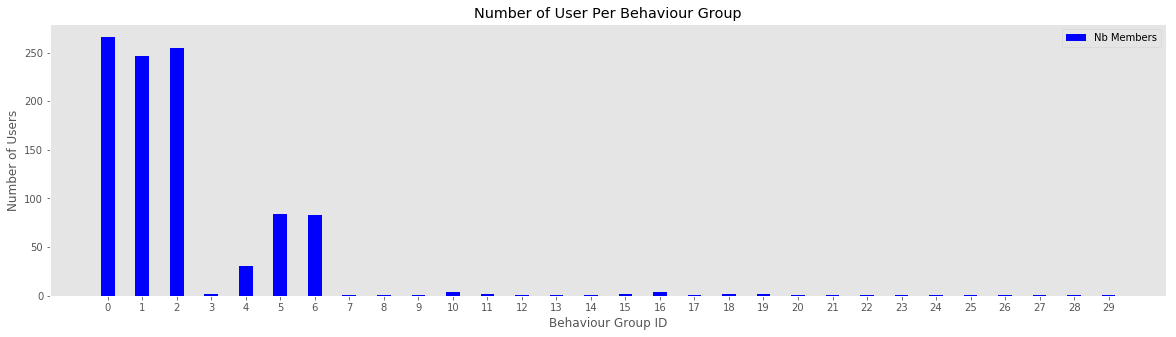

In [23]:
graph_user_distribution_by_behaviour_id(behaviour_group_table, behaviour_average_table, user_transition_score)

## Graph the distribution of by action, weighted by their surprisal score

How to read the graph: 
* Compare the previous graph and this one
* Groups with high number of users and a low surprisal distribution should mainly represent normal users. 
* The different colors should also help to identify which action was mainly used by these users

How to spot outliers?
* Look for groups with a low number of users and a high surprisal distribution.
* The bottom table with the list of actions and scores can also be used to understand the bar above. Low values represent normal actions, high values represents outliers.
* With the distribution of test users used in this notebook, bots should be the main offenders.

Note: The graph below is probably not the best long term solution to graph behaviour groups since it will tend to be crowded with time. It's just for the prouf of concept.

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

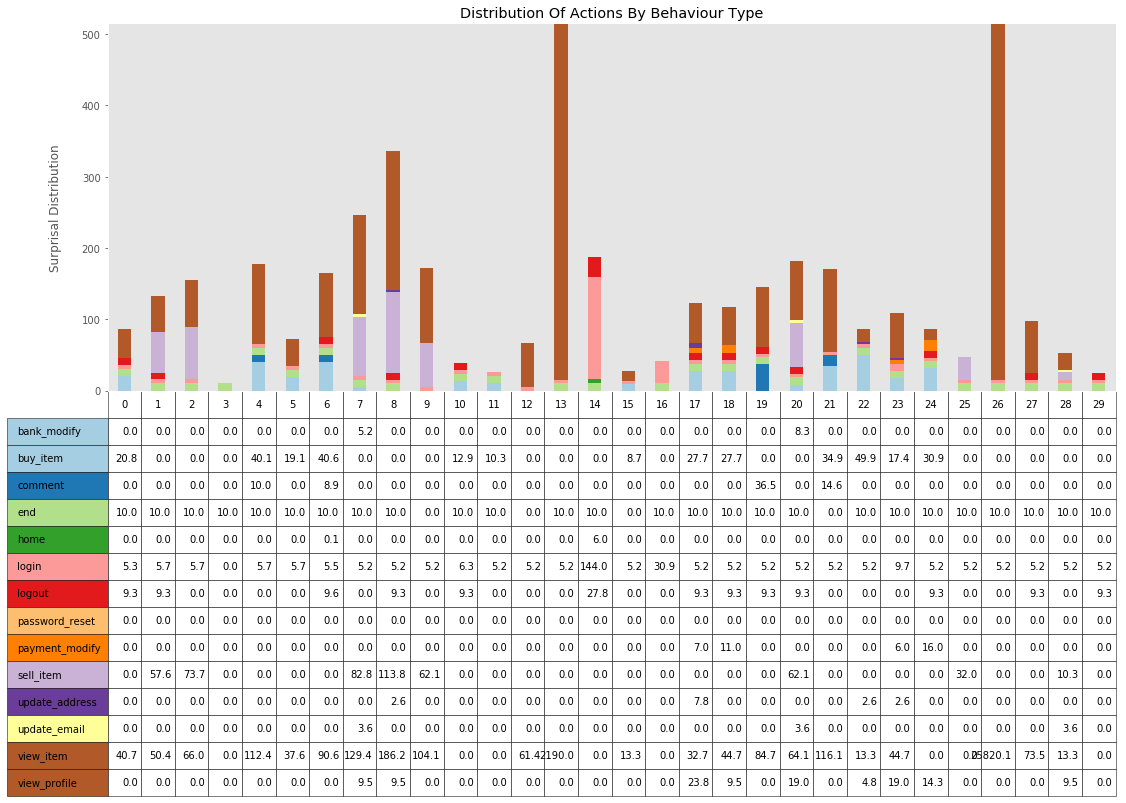

In [24]:
graph_surprisal_distribution_by_action(behaviour_group_table, behaviour_average_table, user_transition_score)

# 4.1 Investigate the behaviour groups to understand the behaviour of the members

The following cell extracts the count of actions for each member of a designated group.


In [25]:
behaviour_group_to_analyse = 26

df_investigate = day1_data.loc[day1_data['user'].isin(behaviour_group_table[behaviour_group_to_analyse])]
df_investigate.groupby(['user', 'status', 'path']).size().unstack(fill_value=0)

path            end  login  view_item
user   status                        
bot269 fail       0      0        133
       success    1      1       4160

# What next: Repeating the analysis on following days

Now that all functions are defined, we can collect logs on subsequent days and classify the users with the previously identified behaviour groups.

If users change their behaviour, they will be reclassified. Inactive users will stay where they are.

Except the "merge_user_transition_score" function, all functions called were previously used. I simply adjusted them to analyse the logs of a different day, in which 200 new users registered.

Event logs are also limited to the daily number of users defined at the beginning of the notebook. This means that some users will come back, and some won't. If a user is reclassified, some behaviour group might end up being empty. Empty groups will be deleted in *behaviour_group_table* but will remain in *behaviour_average_table* for further classification if needed. 

Empty groups will be represented by empty column indexes in the graph, but the behaviour average is preserved  

In [26]:
# New day
start_time = datetime(2019,1,2,0,0)

# Changing the initial seed to get different results
if random_seed:
    random.seed(random_seed + 1)

# How many new users registered today
number_of_new_users = 200
all_user_lists = generate_userlist(all_user_lists, number_of_new_users)

# Select which users will login today
todays_user_lists = random.sample(all_user_lists, number_of_daily_users)

print('Number of active users today:', len(todays_user_lists), todays_user_lists[:5])

if random_seed:
    random.seed(random_seed + 1)
# Generate the logs for the day for the active users
day2_logs = generate_logs(todays_user_lists, start_time)

print(len(day2_logs), 'logs events generated for', len(todays_user_lists), 'users')

# Prepare the data for analysis, by converting them in a pandas dataframe
day2_data = transform_logs_to_pandas(day2_logs)

Number of active users today: 1000 ['merchant', 'merchant', 'merchant', 'buyer', 'buyer']
14325 logs events generated for 1000 users


In [27]:
# Calculate the user transition score based on the previous day surprisal lookup table. 
# We could have recompile is here as well, but this is to be consistant with the suggestion to compare users against
# a previously calculated transition table.
user_transition_score_day2 = get_user_transition_score(day2_data, transition_surprisal, 'user', 'path', 'success')

## Merge the previously calculated transition scores with the new ones
The next function takes the new user transition scores calculated for the second day, and add the values from day 1 for the missing users. This is done to allow us to compare new profiles with previous users when behaviour groups averages are reclaculated.

In [28]:
def merge_user_transition_score(original, newtransitions):        
    for key in original.keys():
        if key not in newtransitions.keys():
            newtransitions[key] = original[key]

    return newtransitions

user_transition_score_merged = merge_user_transition_score(user_transition_score, user_transition_score_day2)
len(user_transition_score_merged)

1496

## Optional (but useful): Identifying unclassified outliers

Same as done on day 1, we can identify outliers just by listing the ones with 2 standard deviations and more.

In [29]:
cumulative_score = [[v,sum(user_transition_score_merged[v].values())] for v in [k for k in list(user_transition_score_merged.keys())]]

df_cumulative_score = pd.DataFrame(cumulative_score, columns=['user', 'surprisal'])

avg = df_cumulative_score['surprisal'].mean()
std = df_cumulative_score['surprisal'].std()
df_cumulative_score['z'] = (df_cumulative_score['surprisal'] - avg) / std

df_cumulative_score.loc[df_cumulative_score['z'] >= 2].sort_values(by=['surprisal'], ascending=False)

,user,surprisal,z
1410,bot269,25835.299997,36.585565
155,bot566,7370.101161,10.294769
979,bot846,3475.896940,4.750191
1292,bot196,2205.136719,2.940879


In [30]:
if random_seed:
    random.seed(random_seed)

unclassified_user_lists = random.sample(list(user_transition_score_merged.keys()), min(len(todays_user_lists), len(list(user_transition_score_merged.keys()))))
print(len(unclassified_user_lists))

1000


In [31]:
%%time

# Classifying observed users
while len(unclassified_user_lists):
    classify_users_in_list(unclassified_user_lists, behaviour_group_table, behaviour_average_table, user_transition_score_merged, maxlimit)

CPU times: user 3.35 s, sys: 11.9 ms, total: 3.36 s
Wall time: 3.49 s


In [32]:
# Cheat cell: list all groups with the distribution of their users, by real type

for k in sorted(behaviour_group_table.keys()):
    type_average = np.mean([sum(user_transition_score_merged[x].values()) for x in behaviour_group_table[k]])
    print(k, type_average, len(behaviour_group_table[k]), cheat_lookup_all_users(behaviour_group_table[k]))

0 100.98774524335987 119 {'buyer': 119}
1 131.6080162881746 334 {'merchant': 334}
2 120.58549477300663 325 {'merchant': 325}
3 9.958552715431011 5 {'merchant': 2, 'attacker': 3}
4 150.34641521654325 42 {'buyer': 42}
5 87.59551906846681 270 {'buyer': 270}
6 139.2143267506827 120 {'buyer': 120}
8 187.13520280322942 4 {'merchant': 4}
9 171.7337497992314 1 {'merchant': 1}
10 52.83406370371358 3 {'buyer': 3}
11 25.48516999608887 1 {'buyer': 1}
12 66.6596423626266 1 {'bot': 1}
14 187.7353117948909 1 {'attacker': 1}
15 71.65916673657047 1 {'buyer': 1}
16 32.32007748331661 5 {'attacker': 4, 'fraudster': 1}
17 179.19745587923728 2 {'buyer': 2}
18 112.92891767762669 2 {'buyer': 1, 'fraudster': 1}
19 201.2824268828862 4 {'spammer': 4}
20 193.9594494514037 2 {'merchant': 2}
21 158.0254621579579 1 {'buyer': 1}
22 85.78987277865463 1 {'fraudster': 1}
23 46.504026462210994 1 {'buyer': 1}
24 85.62652067808291 1 {'fraudster': 1}
25 40.32454711463213 3 {'merchant': 3}
26 25835.299997058537 1 {'bot': 1}


## Graph the behaviour groups and the count of members

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

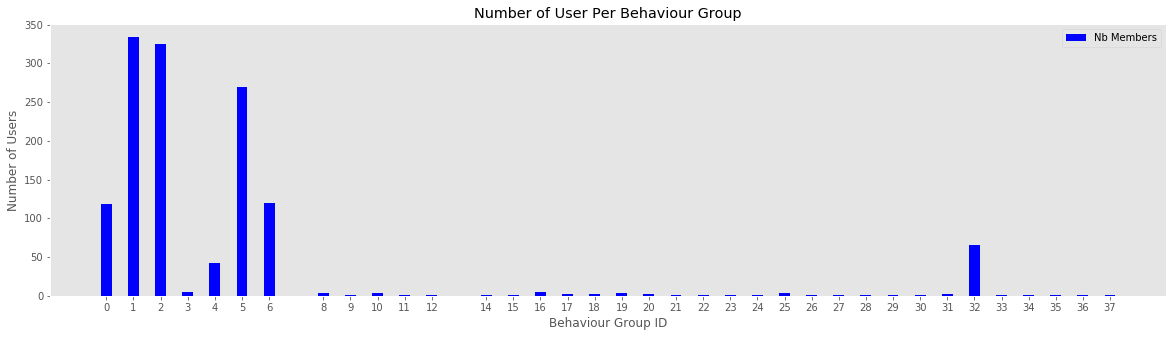

In [33]:
graph_user_distribution_by_behaviour_id(behaviour_group_table, behaviour_average_table, user_transition_score_merged)

## Graph the distribution of by action, weighted by their surprisal score

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

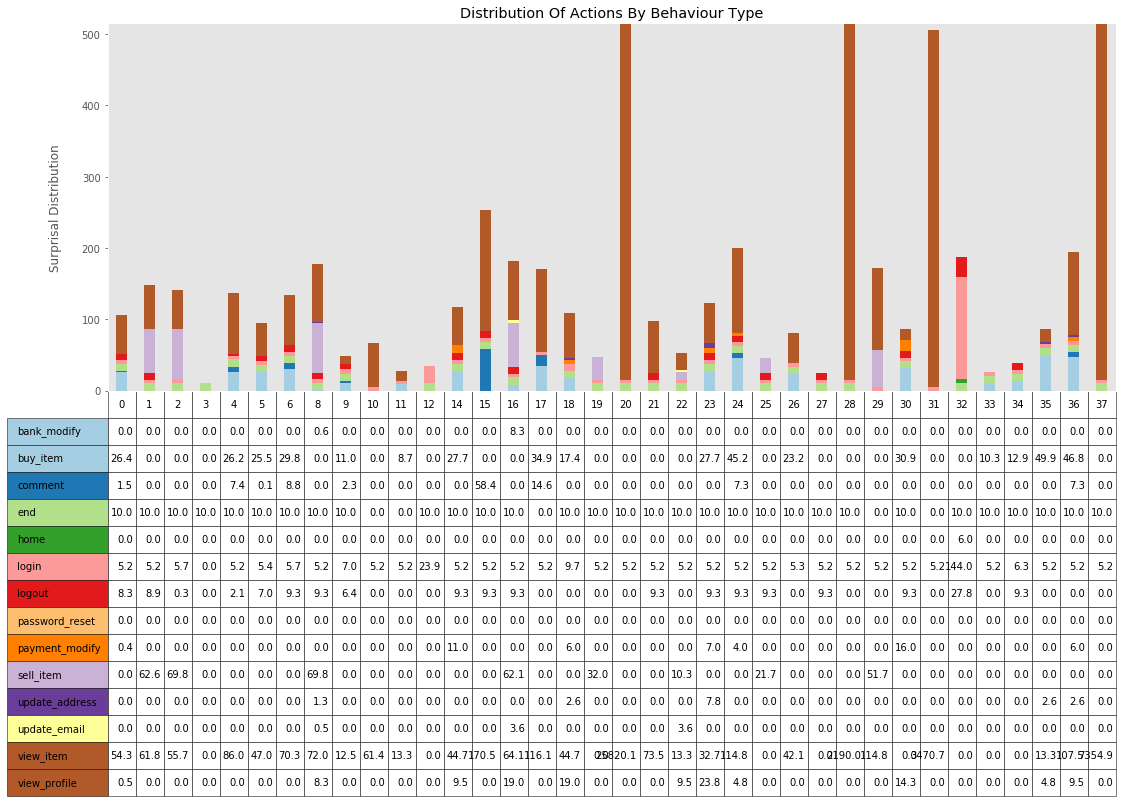

In [34]:
graph_surprisal_distribution_by_action(behaviour_group_table, behaviour_average_table, user_transition_score_merged)

## Investigate the behaviour groups to understand the behaviour of the members

In [35]:
behaviour_group_to_analyse = 37

df_investigate = day2_data.loc[day2_data['user'].isin(behaviour_group_table[behaviour_group_to_analyse])]
df_investigate.groupby(['user', 'status', 'path']).size().unstack(fill_value=0)

path            end  login  view_item
user   status                        
bot566 fail       0      0         35
       success    1      1       1187

# Step 5: Identifying the behaviour group without classifying the users

The method demonstrated previously is good when user sessions are completed and to classify them after the fact, but what if we wanted to classify them as they were using the site?

This would require few major changes in the code:
* Statistics on all actions would need to be calculated on an ongoing basis
* The surprisal value of each action (positive and negative) could be calculated when we queried the system to classify the user
* The classification function would need to return the class without updating the behaviour group and average table, or return "unknown" when the user doesn't match any group. This could be an issue if we only look at the class of user since we wouldn't be able to tell if it was because he didn't perform enough actions to be classified, or because he is currently hammering the site with a new unobserved attack, but if we couple this "unknown" class with the sum of all surprisal values for the actions taken by the user, this would allow the analysts to have a good idea what he is doing anyway.

This section is not presenting a full implementattion of these change, but will demonstrate how a user could be classified without updating the model

## 5.1: Generating the logs for Day 3

This next cell is just like the day 2 initialisation cell, and code would need to be modified to handle a stream of logs, but we can still simulate this behaviour without rewriting the whole notebook by going through each lines of the day3_data pandas dataframe as if it was the parsed output of our logs.

In [36]:
# New day
start_time = datetime(2019,1,3,0,0)

# Changing the initial seed to get different results
if random_seed:
    random.seed(random_seed + 2)

# How many new users registered today
number_of_new_users = 200
all_user_lists = generate_userlist(all_user_lists, number_of_new_users)

# Select which users will login today
todays_user_lists = random.sample(all_user_lists, number_of_daily_users)

print('Number of active users today:', len(todays_user_lists), todays_user_lists[:5])

if random_seed:
    random.seed(random_seed + 2)
# Generate the logs for the day for the active users
day3_logs = generate_logs(todays_user_lists, start_time)

print(len(day3_logs), 'logs events generated for', len(todays_user_lists), 'users')

# Prepare the data for analysis, by converting them in a pandas dataframe
day3_data = transform_logs_to_pandas(day3_logs)

Number of active users today: 1000 ['buyer', 'merchant', 'merchant', 'merchant', 'buyer']
18407 logs events generated for 1000 users


## 5.2: Calculating the user transition surprisal score for each users

This cell is calculating the transition surprisal score for the full day, and would need to be modified to handle a stream of logs.

In [37]:
user_transition_score_day3 = get_user_transition_score(day3_data, transition_surprisal, 'user', 'path', 'success')

user_transition_score_merged = merge_user_transition_score(user_transition_score_merged, user_transition_score_day3)
print('Total number of transition scores:', len(user_transition_score_merged))


Total number of transition scores: 1770


In [38]:
if random_seed:
    random.seed(random_seed + 11)
# sample_users = random.sample(, 20)
listing_of_users = list(day3_data['user'].unique())

## 5.3 Model Querying Functions
This next cell introduces a modified version of the classify_candidates_average function previously used. The main difference is that it will perform the classification with a much wider Kullback-Leibler divergence limit, and return a list of candidate instead of the most probable one, as well as the profile of the class for comparison. 

In [39]:
def classify_candidate_query(candidate_name, behaviour_type_average, score, limit = 7):
    potential_matching_type = {}
    
    for be, be_average in behaviour_type_average.items():
        result = compare_profiles(score[candidate_name], be_average, limit)
            
        if result['test'] == True:
            potential_matching_type[be] = { 
                'group': be,
                'kldp': result['kldp'], 
                'kldq': result['kldq'], 
                'proximity': result['kldp']**2 + result['kldq']**2,
                'profile': behaviour_type_average[be]
            }

    if len(potential_matching_type.keys()) == 0:
        return {}
    else:
        matching_scores = {x: potential_matching_type[x]['proximity'] for x in potential_matching_type.keys()}
        best = min(matching_scores, key=matching_scores.get)
        return {
            'best': potential_matching_type[best],
            'others': potential_matching_type
        }

candidate = listing_of_users[0]
result = classify_candidate_query(candidate, behaviour_average_table, user_transition_score_merged, 20)

In [40]:
# This is an ugly function that takes the candidate profile and the potential classes and present them in a report
# The first row of the report is the candidate (groupe -1), then we can compare each lines with the candidate line
# and see where the potential class differs from the candidate

def classify_candidate_detail(candidate, result, score):
    reports = []
    prefix = ['group', 'kldp', 'kdlq', 'proximity']
    headers = []
    column = {}
    
    for key, value in result['best']['profile'].items():
        if key not in prefix:
            column[key] = 1

    for key, value in score[candidate].items():
        if key not in prefix:
            column[key] = 1

    columns = sorted(column.keys())
    headers.extend(prefix)
    headers.extend(columns)

    ## Adding the candidate line in the report
    candidate_rows = [-1 for x in prefix]
    for action in columns: 
        candidate_rows.append(score[candidate][action])
    reports.append(candidate_rows)

    ## Adding all potential classes in the report
    for key, value in result['others'].items():
        rows = [key, value['kldp'], value['kldq'], value['proximity']]
        for action in columns: 
            rows.append(value['profile'][action])
        reports.append(rows)

    # transforming the array in a dataframe to simplify sorting
    df_report = pd.DataFrame(reports, columns=headers)

    return df_report.sort_values(by=['proximity'])

# Display the report
print('report for {}. score of {}'.format(candidate,sum(user_transition_score_merged[candidate].values())))
print('matching with behaviour group:', classify_candidates_average(candidate, behaviour_average_table, user_transition_score_merged, 20))

classify_candidate_detail(candidate, result, user_transition_score_merged)

report for merchant495. score of 38.863149192771495
matching with behaviour group: 2


,group,kldp,kdlq,proximity,bank_modify,buy_item,comment,end,home,login,logout,password_reset,payment_modify,sell_item,update_address,update_email,view_item,view_profile
0,-1,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,9.958553,0.0,5.222837,0.000000,0.0,0.0,10.347068,0.0,0.000000,13.334692,0.000000
2,2,-0.245137,0.350519,0.182956,0.000000,0.000000,0.000000,9.958453,0.0,5.682948,0.288455,0.0,0.0,69.794401,0.0,0.000000,55.719095,0.000000
1,1,-0.018738,8.966408,80.396818,0.000000,0.000000,0.000000,9.958553,0.0,5.235491,8.921256,0.0,0.0,62.599900,0.0,0.000000,61.840552,0.000000
4,9,9.958553,0.031587,99.173770,0.000000,0.000000,0.000000,0.000000,0.0,5.222837,0.000000,0.0,0.0,51.735338,0.0,0.000000,114.775575,0.000000
8,28,-0.311792,13.094738,171.569364,0.000000,0.000000,0.000000,9.958553,0.0,5.222837,0.000000,0.0,0.0,10.347068,0.0,3.584963,13.334692,9.509775
6,25,13.334692,0.015365,177.814254,0.000000,0.000000,0.000000,9.958553,0.0,5.222837,0.000000,0.0,0.0,32.041203,0.0,0.000000,0.000000,0.000000
7,27,10.332045,9.267003,192.628490,0.000000,0.000000,0.000000,9.958553,0.0,5.222837,9.269127,0.0,0.0,0.000000,0.0,0.000000,73.462334,0.000000
9,31,13.319666,9.276548,263.467841,0.000000,0.000000,0.000000,9.958553,0.0,5.222837,9.269127,0.0,0.0,21.694135,0.0,0.000000,0.000000,0.000000
3,7,-0.455401,18.331507,336.251542,5.169925,0.000000,0.000000,9.958553,0.0,5.222837,0.000000,0.0,0.0,82.776541,0.0,3.584963,129.419431,9.509775
5,10,9.781859,19.703352,483.906832,0.000000,11.009703,2.282431,9.958553,0.0,6.967410,6.372525,0.0,0.0,0.000000,0.0,0.000000,12.516465,0.000000


Note about the classification:
* When we build our behaviour group table, we use a smaller Kellback Leibler Divergence limit (5), but here, when querying, and to compare with other classes, we can affort to search a bit more wider. If used alone, this could results in false positives, so external factors should also be taken in consideration.

Note about how to read the Kellback Leibler Divergence P and Q columns (kdlp, kdlq):
* the smaller the number, the more the candidate ressemble to the target class, but this is not symetric, so the candidate can have similarities with the group, but be missing information as well. In that case, kldp will be bigger.
* The scores in the actions columns (bank_modify, buy_items, etc.) is the sum of all surprisal values for the actions taken by the users. A larger value means that the user did something unusual, or a large amount of usual actions.

In [41]:
chrono_stop = timeit.default_timer()

print('Complete run time: ', chrono_stop - chrono_start) 


Complete run time:  30.74148744199192
